# Lab 01 : Vanilla Graph Transformers - demo

Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020   
https://arxiv.org/pdf/2012.09699.pdf

### Xavier Bresson  

<br>
Notebook goals :<br>  
• Implement vanilla graph transformers (i.e. no positional encoding) with DGL <br> 
• Compare performance of GT with GCN <br> 


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/07_Graph_Transformers'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl # Install DGL
    

In [1]:
# Libraries
import dgl
from dgl.data import MiniGCDataset
import dgl.function as fn
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import time


# Visualize the artifical graph dataset used in this notebook

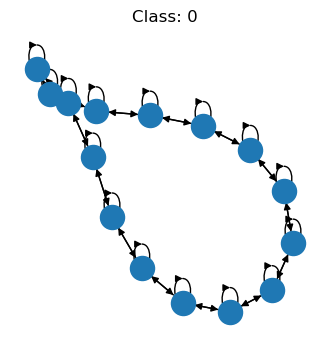

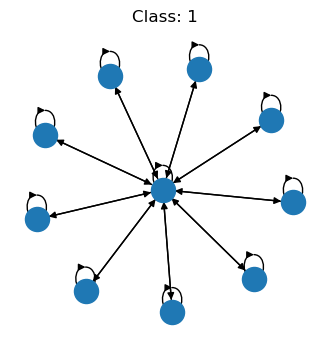

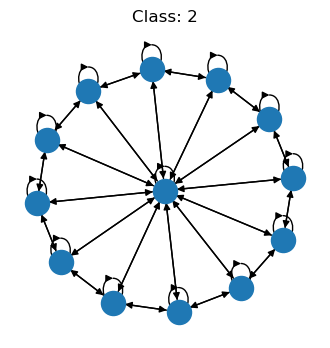

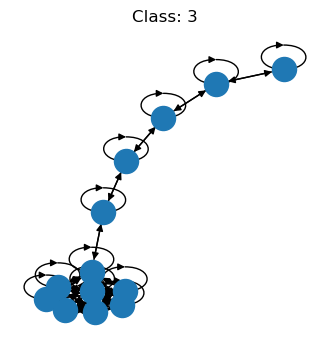

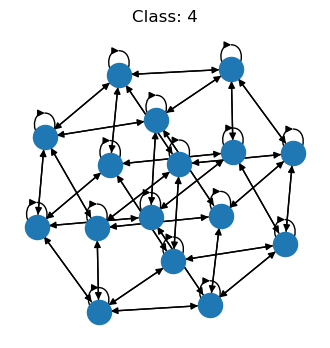

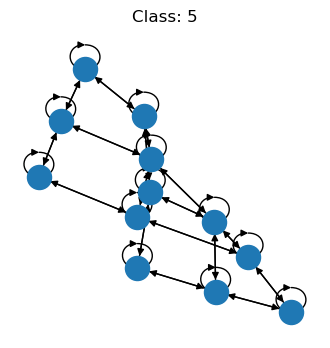

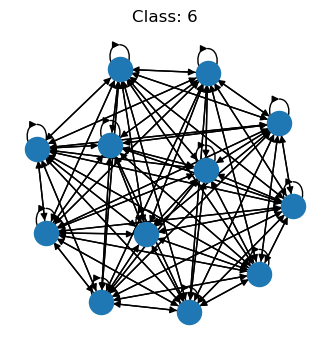

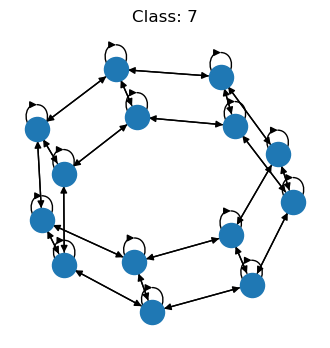

In [3]:
dataset = MiniGCDataset(8, 10, 20) # DGL artificial dataset

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = dataset[c] 
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(4,4))
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Generate train, val and test datasets 

## Add node and edge features

In [4]:
# Add node and edge features to graphs
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float() # node feature is node in-degree
    return dataset

# Generate graph datasets
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
valset = add_node_edge_features(valset)
print(trainset[0])


(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={}), tensor(0))


# Define the collate function to prepare a batch of DGL graphs and test it

In [5]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels (here class label)
    return batch_graphs, batch_labels


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())


Graph(num_nodes=135, num_edges=1081,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
tensor([5, 7, 3, 7, 6, 0, 4, 6, 1, 6])
batch_x: torch.Size([135, 1])


# Design the class of vanilla GraphTransformer networks with DGL

Node update equation:  
\begin{eqnarray}
\bar{h}^{\ell} &=& \textrm{BN/LN} \left( h^{\ell} + \textrm{gMHA} (h^{\ell}) \right) \in \mathbb{R}^{N\times d}\\
h^{\ell+1} &=& \textrm{BN/LN} \left( \bar{h}^{\ell} + \textrm{MLP} (\bar{h}^{\ell}) \right) \in \mathbb{R}^{N\times d}\\
&&\textrm{with } \textrm{gMHA}(h)=\textrm{Concat}_{k=1}^H \left( \textrm{gHA}(h_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, W_O\in \mathbb{R}^{d\times d} \\
&&\quad\quad\ \textrm{gHA}(h)=\textrm{Softmax}\left( A_G \odot \frac{QK^T}{\sqrt{d'}} \right) V \in \mathbb{R}^{N\times d'=d/H},\ A_G\in \mathbb{R}^{N\times N} \textrm{ (graph adjacency matrix)}\\
&&\quad\quad\ \textrm{gHA}(h)_i= \sum_{j\in \mathcal{N}_i} \underbrace{\frac{\exp(q_i^T k_j/\sqrt{d'})}{ \sum_{j'\in\mathcal{N}_i} \exp(q_i^T k_{j'}/\sqrt{d'}) }}_{\textrm{graph attention score}_{ij}} v_j\ \textrm{ (point-wise equation)}\\
&&\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d'=d/H}, W_Q, W_K, W_V\in \mathbb{R}^{d'\times d'}\\
h^{\ell=0} &=& \textrm{LL}(h_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature)}
\end{eqnarray}

In [6]:
# class MLP layer for classification
class MLP_layer(nn.Module): 
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

        
# class graph multi head attention layer  
class graph_MHA_layer(nn.Module): # MHA = Multi Head Attention
    
    def __init__(self, hidden_dim, head_hidden_dim, num_heads): # hidden_dim = d
        super().__init__()
        self.head_hidden_dim = head_hidden_dim # head_hidden_dim = d' = d/K
        self.num_heads = num_heads # number of heads = K
        self.WQ = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True) # define K x WQ matrix of size=(d',d')
        self.WK = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WV = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        
    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges): 
        qikj = (edges.src['K'] * edges.dst['Q']).sum(dim=2).unsqueeze(2) # all dot products q_i^T * k_j, size=(E,K,1), edges.src/dst[].size=(E,K,d')
        #expij = torch.exp( qikj / torch.sqrt(torch.tensor(self.head_hidden_dim)) ) # blow up!
        expij = torch.exp( (qikj / torch.sqrt(torch.tensor(self.head_hidden_dim))).clamp(-5, 5) ) # exp_ij = exp( q_i^T * k_j / sqrt(d') ), size=(E,K,1)
        vj = edges.src['V'] # size=(E,K,d')
        return {'expij' : expij, 'vj' : vj} 
    
    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={hj, eij} sent to node dst/i with Step 1
    #                   and sum/mean over the graph neigbors j in Ni
    def reduce_func(self, nodes):
        expij = nodes.mailbox['expij'] # size=(N,|Nj|,K,1), |Nj|=num_neighbors
        vj = nodes.mailbox['vj'] # size=(N,|Nj|,K,d')
        numerator = torch.sum( expij * vj, dim=1 ) # sum_j exp_ij . v_j, size=(N,K,d')
        denominator = torch.sum( expij, dim=1 ) # sum_j' exp_ij', size=(N,K,1)
        h = numerator / denominator # h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij', size=(N,K,d')
        return {'h' : h} 
    
    def forward(self, g, h):
        Q = self.WQ(h) # size=(N, d)
                       # computational trick to compute quickly K linear transformations h_k.WQ of size=(N, d')
                       # first compute linear transformation h.WQ of size=(N, d)
                       # then reshape h.WQ of size=(N, K, d'=d/K)
        K = self.WK(h) # size=(N, d)
        V = self.WV(h) # size=(N, d)
        g.ndata['Q'] = Q.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['K'] = K.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['V'] = V.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.update_all(self.message_func, self.reduce_func) # compute with DGL the graph MHA 
        gMHA = g.ndata['h'] # size=(N, K, d'=d/K)
        return gMHA
    
    
# class GraphTransformer layer  
class GraphTransformer_layer(nn.Module):
    
    def __init__(self, hidden_dim, num_heads, norm, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim # hidden_dim = d
        self.num_heads = num_heads # number of heads = K
        self.dropout = dropout # dropout value
        self.gMHA = graph_MHA_layer(hidden_dim, hidden_dim//num_heads, num_heads) # graph MHA layer
        self.WO = nn.Linear(hidden_dim, hidden_dim) # LL
        self.norm = norm # type of layer normalization
        if self.norm == 'LN': # layer normalization
            self.layer_norm1 = nn.LayerNorm(hidden_dim)
            self.layer_norm2 = nn.LayerNorm(hidden_dim)
        elif self.norm == 'BN': # batch normalization
            self.layer_norm1 = nn.BatchNorm1d(hidden_dim)
            self.layer_norm2 = nn.BatchNorm1d(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP
        
    def forward(self, g, h): 
        
        # Self-attention layer
        h_rc = h # size=(N,d), V=num_nodes, for residual connection
        h_MHA = self.gMHA(g, h) # MHA, size=(N, K, d'=d/K)
        h_MHA = h_MHA.view(-1, self.hidden_dim) # size=(N, d)
        h_MHA = F.dropout(h_MHA, self.dropout, training=self.training) # dropout, size=(N, d)
        h_MHA = self.WO(h_MHA) # LL, size=(N, d)
        h = h_rc + h_MHA # residual connection, size=(N, d)
        h = self.layer_norm1(h) # layer normalization, size=(N, d)
        
        # Fully-connected layer
        h_rc = h # for residual connection, size=(N, d)
        h_MLP = self.linear1(h) # LL, size=(N, d)
        h_MLP = torch.relu(h_MLP) # size=(N, d)
        h_MLP = F.dropout(h_MLP, self.dropout, training=self.training) # dropout, size=(N, d)
        h_MLP = self.linear2(h_MLP) # LL, size=(N, d)
        h = h_rc + h_MLP # residual connection, size=(N, d)
        h = self.layer_norm2(h) # layer normalization, size=(N f, d)
        return h
    
    
# class Graph Transformer network
class GraphTransformer_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GraphTransformer_net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        num_heads = net_parameters['num_heads']
        norm = net_parameters['norm'] 
        L = net_parameters['L']
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GraphTransformer_layers = nn.ModuleList([ GraphTransformer_layer(hidden_dim, num_heads, norm) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h) # size=(num_nodes, hidden_dim)
        
        # graph convnet layers
        for GT_layer in self.GraphTransformer_layers:
            h = GT_layer(g,h) # size=(num_nodes, hidden_dim)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors, size=(num_graphs, hidden_dim)
        y = self.MLP_layer(y) # size=(num_graphs, num_classes)    
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().sum().item()
        return acc
    

# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['num_heads'] = 8
net_parameters['norm'] = 'BN' 
#net_parameters['norm'] = 'LN' 
net_parameters['L'] = 4
net = GraphTransformer_net(net_parameters)
print(net)

batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
batch_x = batch_graphs.ndata['feat']
batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_x)
print(batch_scores.size())


GraphTransformer_net(
  (embedding_h): Linear(in_features=1, out_features=128, bias=True)
  (embedding_e): Linear(in_features=1, out_features=128, bias=True)
  (GraphTransformer_layers): ModuleList(
    (0-3): 4 x GraphTransformer_layer(
      (gMHA): graph_MHA_layer(
        (WQ): Linear(in_features=128, out_features=128, bias=True)
        (WK): Linear(in_features=128, out_features=128, bias=True)
        (WV): Linear(in_features=128, out_features=128, bias=True)
      )
      (WO): Linear(in_features=128, out_features=128, bias=True)
      (layer_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layer_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_fea

/Users/xbresson/miniconda3/envs/gnn_course_apr23/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


# Train the network

In [8]:
def run_one_epoch(net, data_loader, train=True):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = net.loss(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += net.accuracy(batch_scores, batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc 


# dataset loaders
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['num_heads'] = 8
net_parameters['norm'] = 'BN' 
#net_parameters['norm'] = 'LN' 
net_parameters['L'] = 4
net = GraphTransformer_net(net_parameters)

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
for epoch in range(50):
    start = time.time()
    epoch_train_loss, epoch_train_acc = run_one_epoch(net, train_loader, True)
    with torch.no_grad(): 
        epoch_test_loss, epoch_test_acc = run_one_epoch(net, test_loader, False)
        epoch_val_loss, epoch_val_acc = run_one_epoch(net, val_loader, False)  
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
    print('                      train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc, epoch_val_acc))
    

Epoch 0, time 1.1100, train_loss: 1.9991, test_loss: 1.9613, val_loss: 1.9613
                      train_acc: 0.1857, test_acc: 0.2200, val_acc: 0.2200
Epoch 1, time 1.1601, train_loss: 1.9191, test_loss: 1.8931, val_loss: 1.8931
                      train_acc: 0.2571, test_acc: 0.2400, val_acc: 0.2400
Epoch 2, time 1.0455, train_loss: 1.8576, test_loss: 1.8298, val_loss: 1.8298
                      train_acc: 0.4086, test_acc: 0.5300, val_acc: 0.5300
Epoch 3, time 1.4232, train_loss: 1.7865, test_loss: 1.7777, val_loss: 1.7777
                      train_acc: 0.5857, test_acc: 0.6200, val_acc: 0.6200
Epoch 4, time 1.3094, train_loss: 1.7220, test_loss: 1.7163, val_loss: 1.7163
                      train_acc: 0.5886, test_acc: 0.6400, val_acc: 0.6400
Epoch 5, time 1.2414, train_loss: 1.6577, test_loss: 1.6644, val_loss: 1.6644
                      train_acc: 0.6400, test_acc: 0.6500, val_acc: 0.6500
Epoch 6, time 1.1697, train_loss: 1.5930, test_loss: 1.5989, val_loss: 1.5989
    